In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import astropy.table as astTable
from lsst.daf.butler import Butler
import lsst.geom as geom
import xlens
from xlens.process_pipe.anacal_detect import AnacalDetectPipeConfig, AnacalDetectPipe
from astropy.io import ascii as astascii
import fitsio
import glob

from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import anacal

In [2]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = True
task = AnacalDetectPipe(config=config)

In [18]:
full = fitsio.read("tracts_fdfc_v1_trim6.fits")
entry = full[29530]
tract_id = entry["tract"]
patch_db = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
tract_id = 10065
patch_id = 31
print(tract_id, patch_id)

10065 31


In [19]:
%%time
patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
image_dir = (
    "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_calexp"
)
files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/i/*"))
fname = files[0]
exposure = afwImage.ExposureF.readFits(fname)
mask_fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_mask/{tract_id}/{patch_id}/mask2.fits"
bmask = fitsio.read(mask_fname) 
n_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_nImage"
nim_dir = f"{n_dir}/{tract_id}/{patch_id}/i"
nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
nImage = fitsio.read(nim_fname)
bmask = (bmask | (nImage <=2).astype(np.int16))
noise_corr = fitsio.read("noise_correlation2.fits")

seed = (tract_id * 1000 + patch_id) #* 5
data = task.anacal.prepare_data(
    exposure=exposure,
    seed=seed,
    noise_corr=noise_corr,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    mask_array=bmask,
)
catalog = task.anacal.run(**data)
gm = (catalog["mask_value"] < 30) & (catalog["is_primary"])
catalog = catalog[gm]

CPU times: user 54.4 s, sys: 1.3 s, total: 55.7 s
Wall time: 55.9 s


In [20]:
mask_plane_dict = exposure.getMask().getMaskPlaneDict()

# Print it
for name, bit in mask_plane_dict.items():
    print(f"{name}: bit {bit}")

BAD: bit 0
BRIGHT_OBJECT: bit 10
CLIPPED: bit 11
CR: bit 3
CROSSTALK: bit 12
DETECTED: bit 5
DETECTED_NEGATIVE: bit 6
EDGE: bit 4
INEXACT_PSF: bit 13
INTRP: bit 2
NOT_DEBLENDED: bit 14
NO_DATA: bit 8
REJECTED: bit 15
SAT: bit 1
SENSOR_EDGE: bit 16
STREAK: bit 17
SUSPECT: bit 7
UNMASKEDNAN: bit 18
VIGNETTED: bit 9


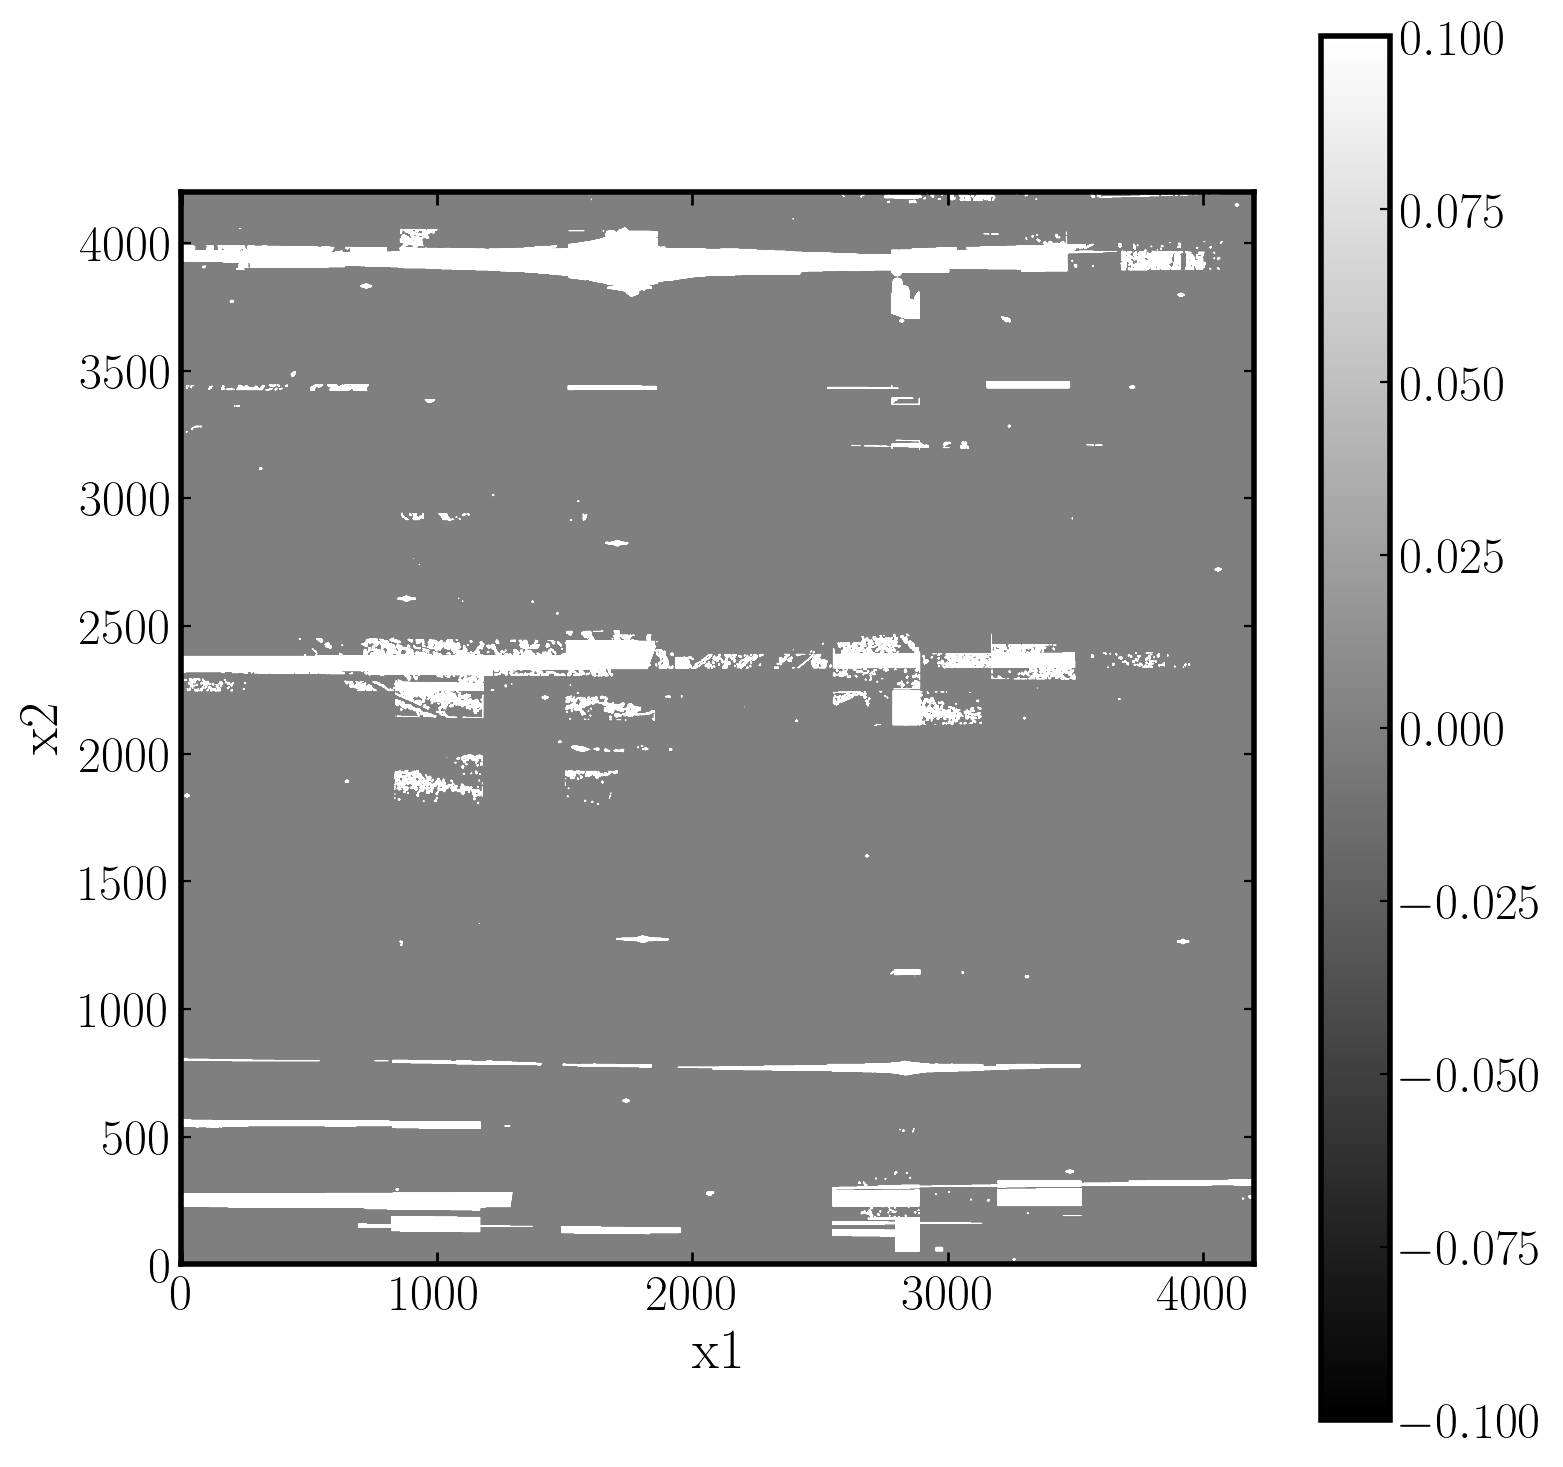

In [21]:
nImage = fitsio.read(nim_fname)
image =  (nImage<=2).astype(int) #nImage#
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.colorbar(im)
plt.show()

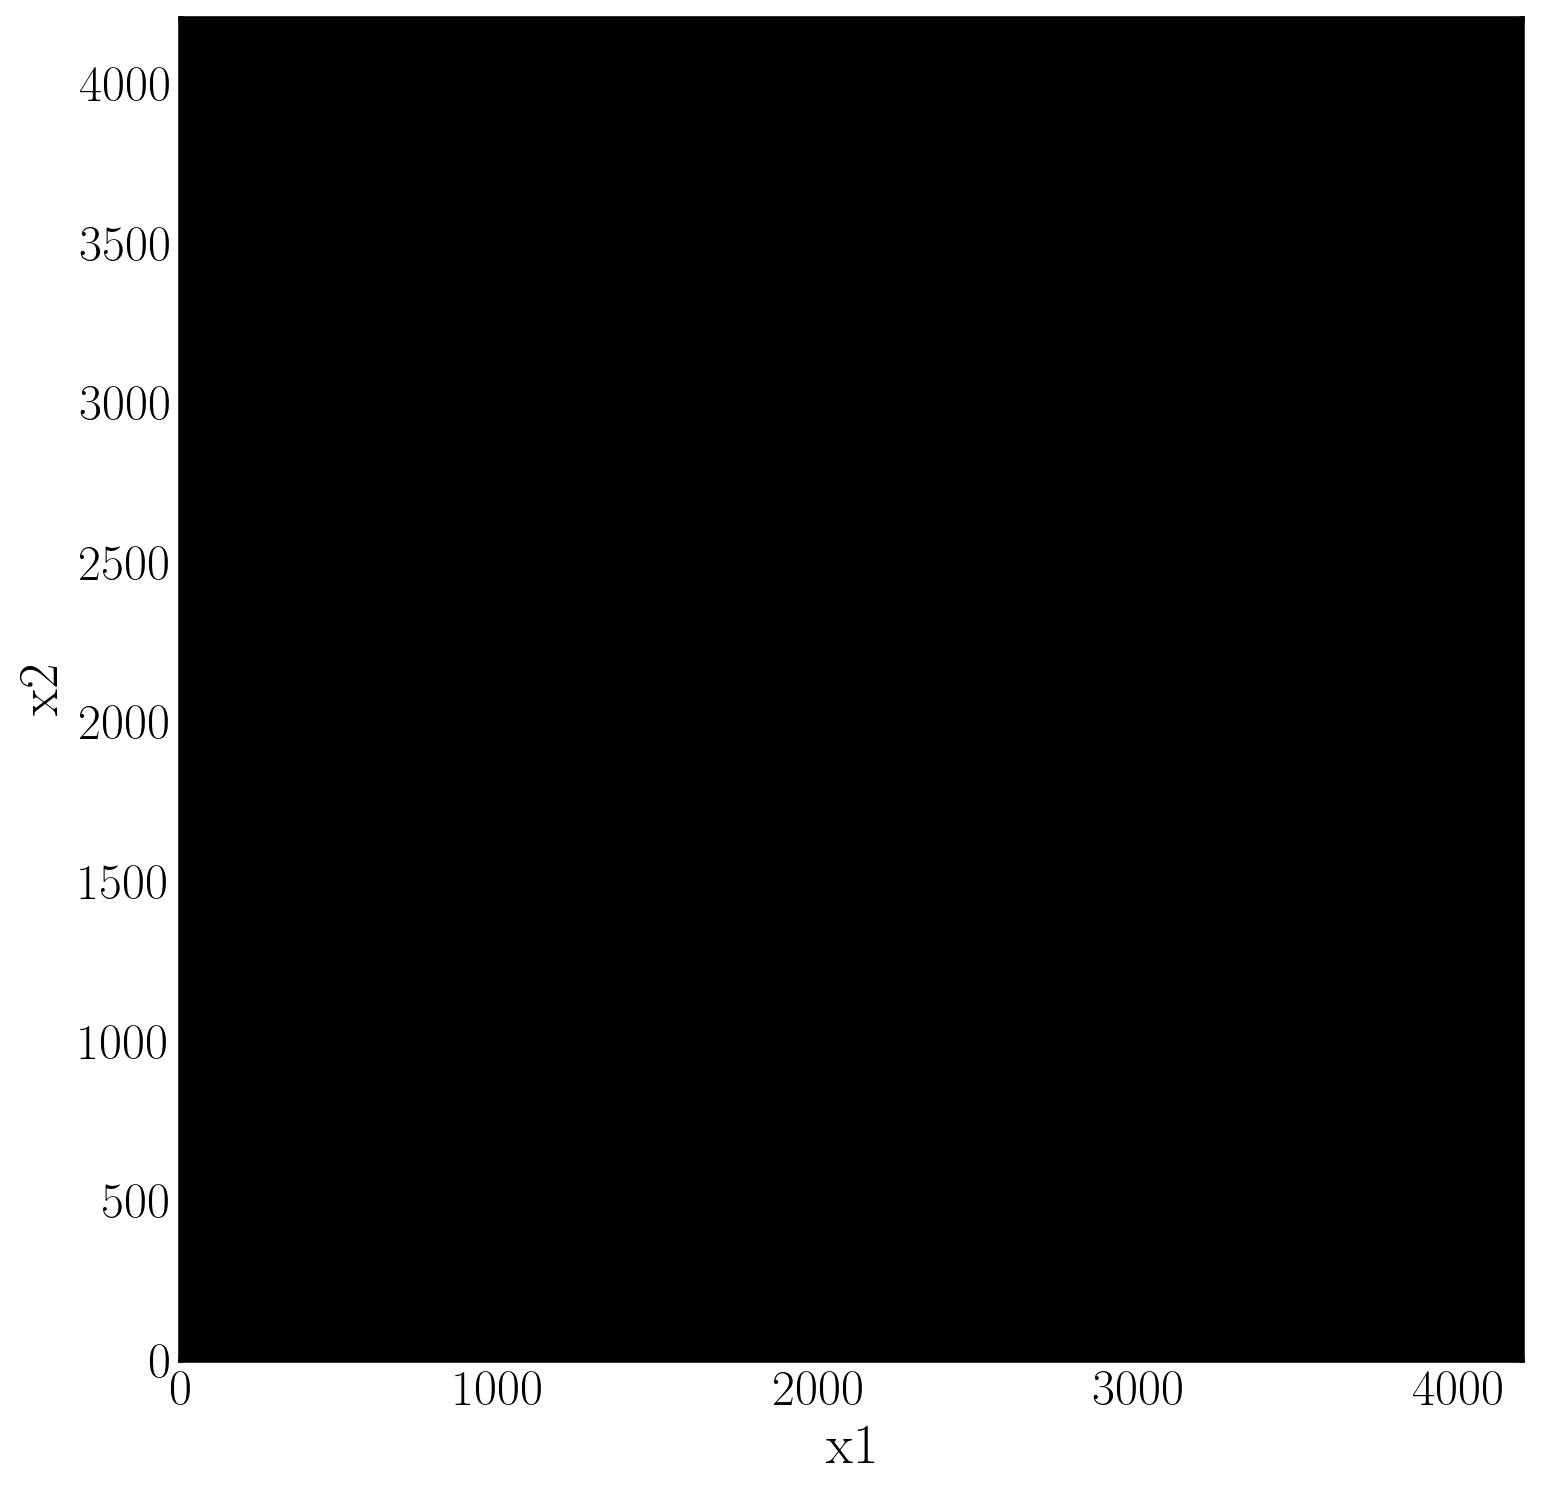

In [22]:
image = data["mask_array"]
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [ ]:
image = data["gal_array"]
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [ ]:
image = exposure.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

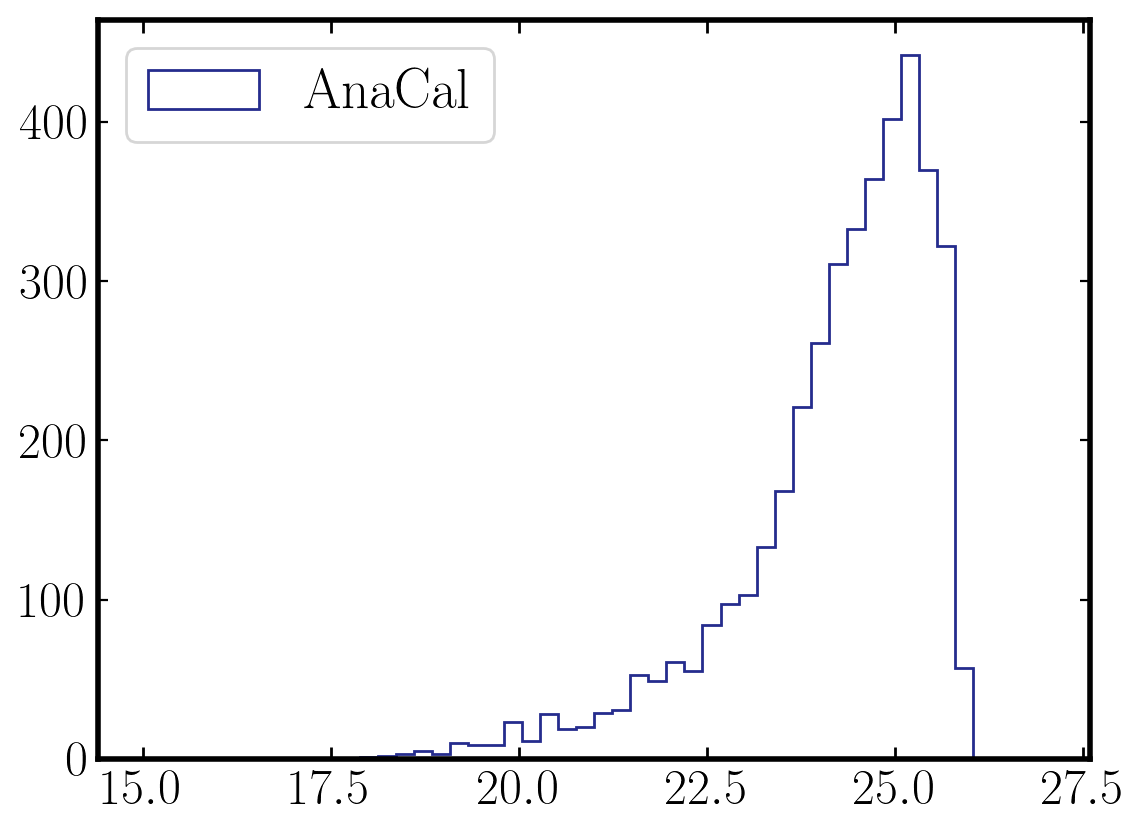

In [34]:
plt.hist(27 - np.log10(catalog["flux"]) * 2.5, histtype="step", density=False, bins=50, range=(15, 27), label="AnaCal")
plt.legend()

-99.42643082217215
98.7151283652453


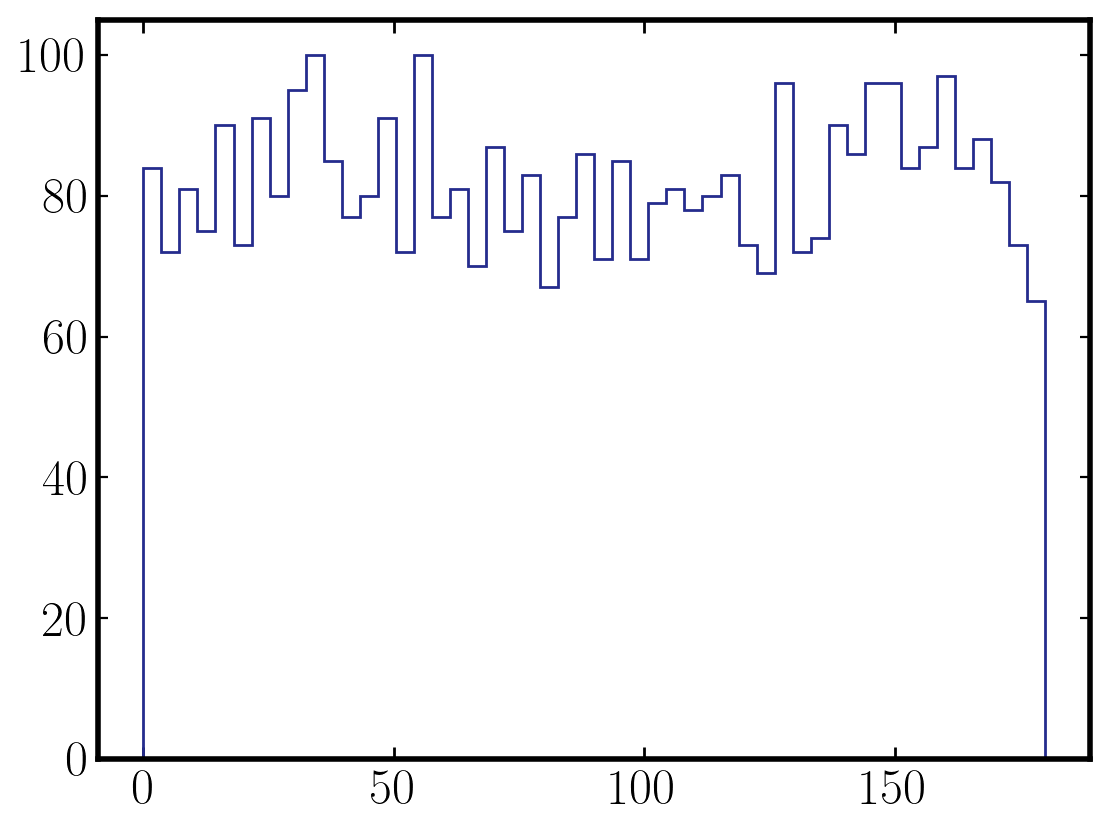

In [35]:
plt.close()
plt.hist(np.degrees(catalog["t"]) % 180, histtype="step", density=False, bins=50)
print(np.min(np.degrees(catalog["t"])))
print(np.max(np.degrees(catalog["t"])))

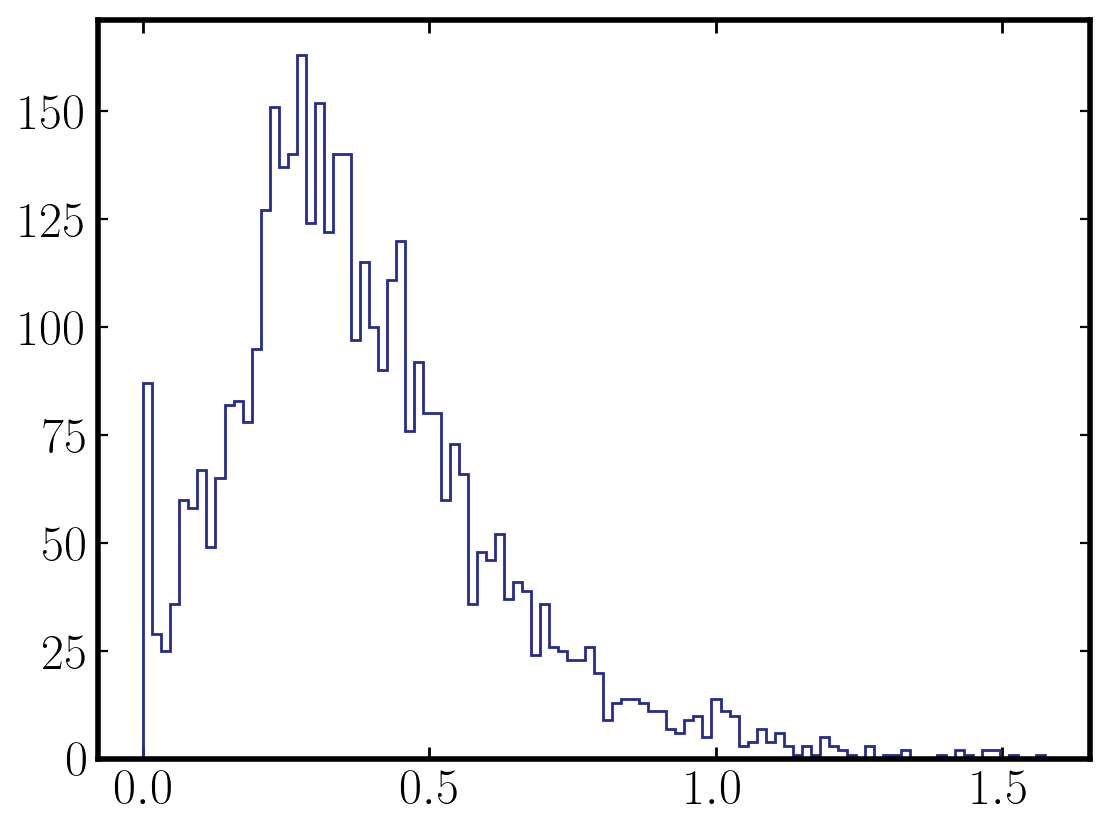

In [36]:
plt.close()
_=plt.hist(np.sqrt(catalog["a1"] **2 + catalog["a2"] **2), histtype="step", density=False, bins=100)

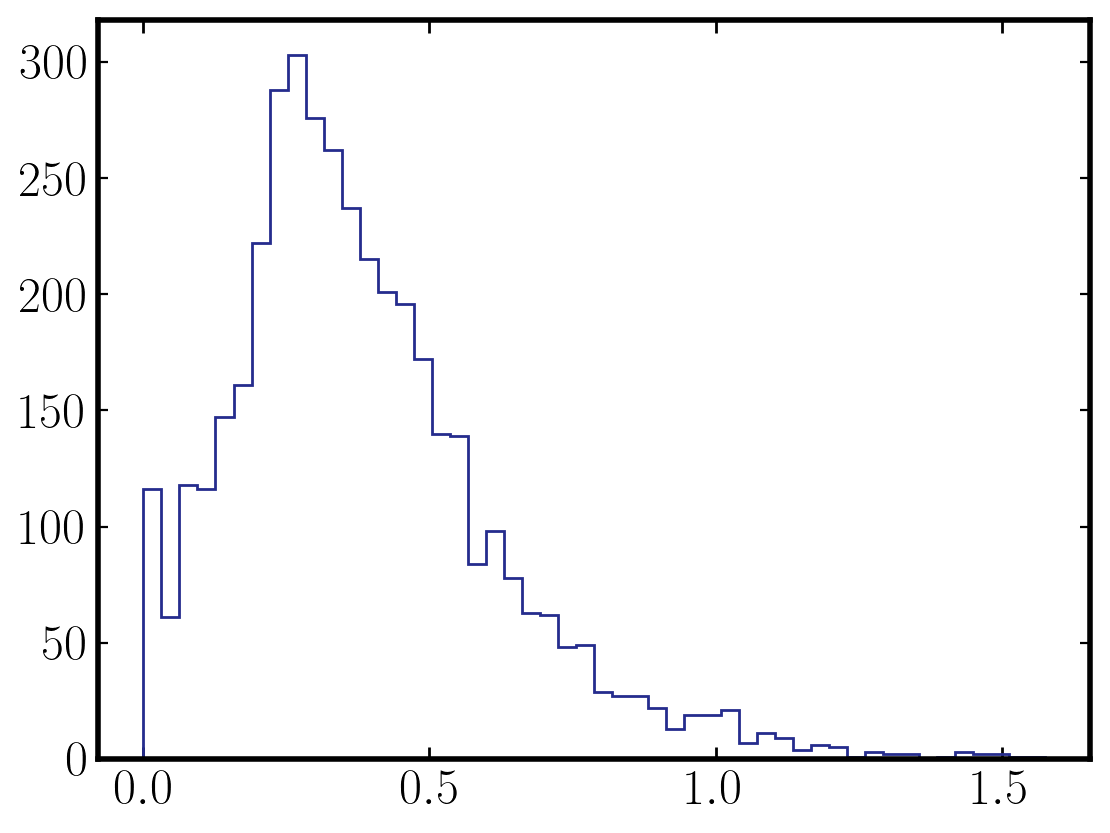

In [37]:
plt.close()
_=plt.hist(np.sqrt(catalog["a2"] ** 2.0 + catalog["a1"] ** 2.0), histtype="step", density=False, bins=50)

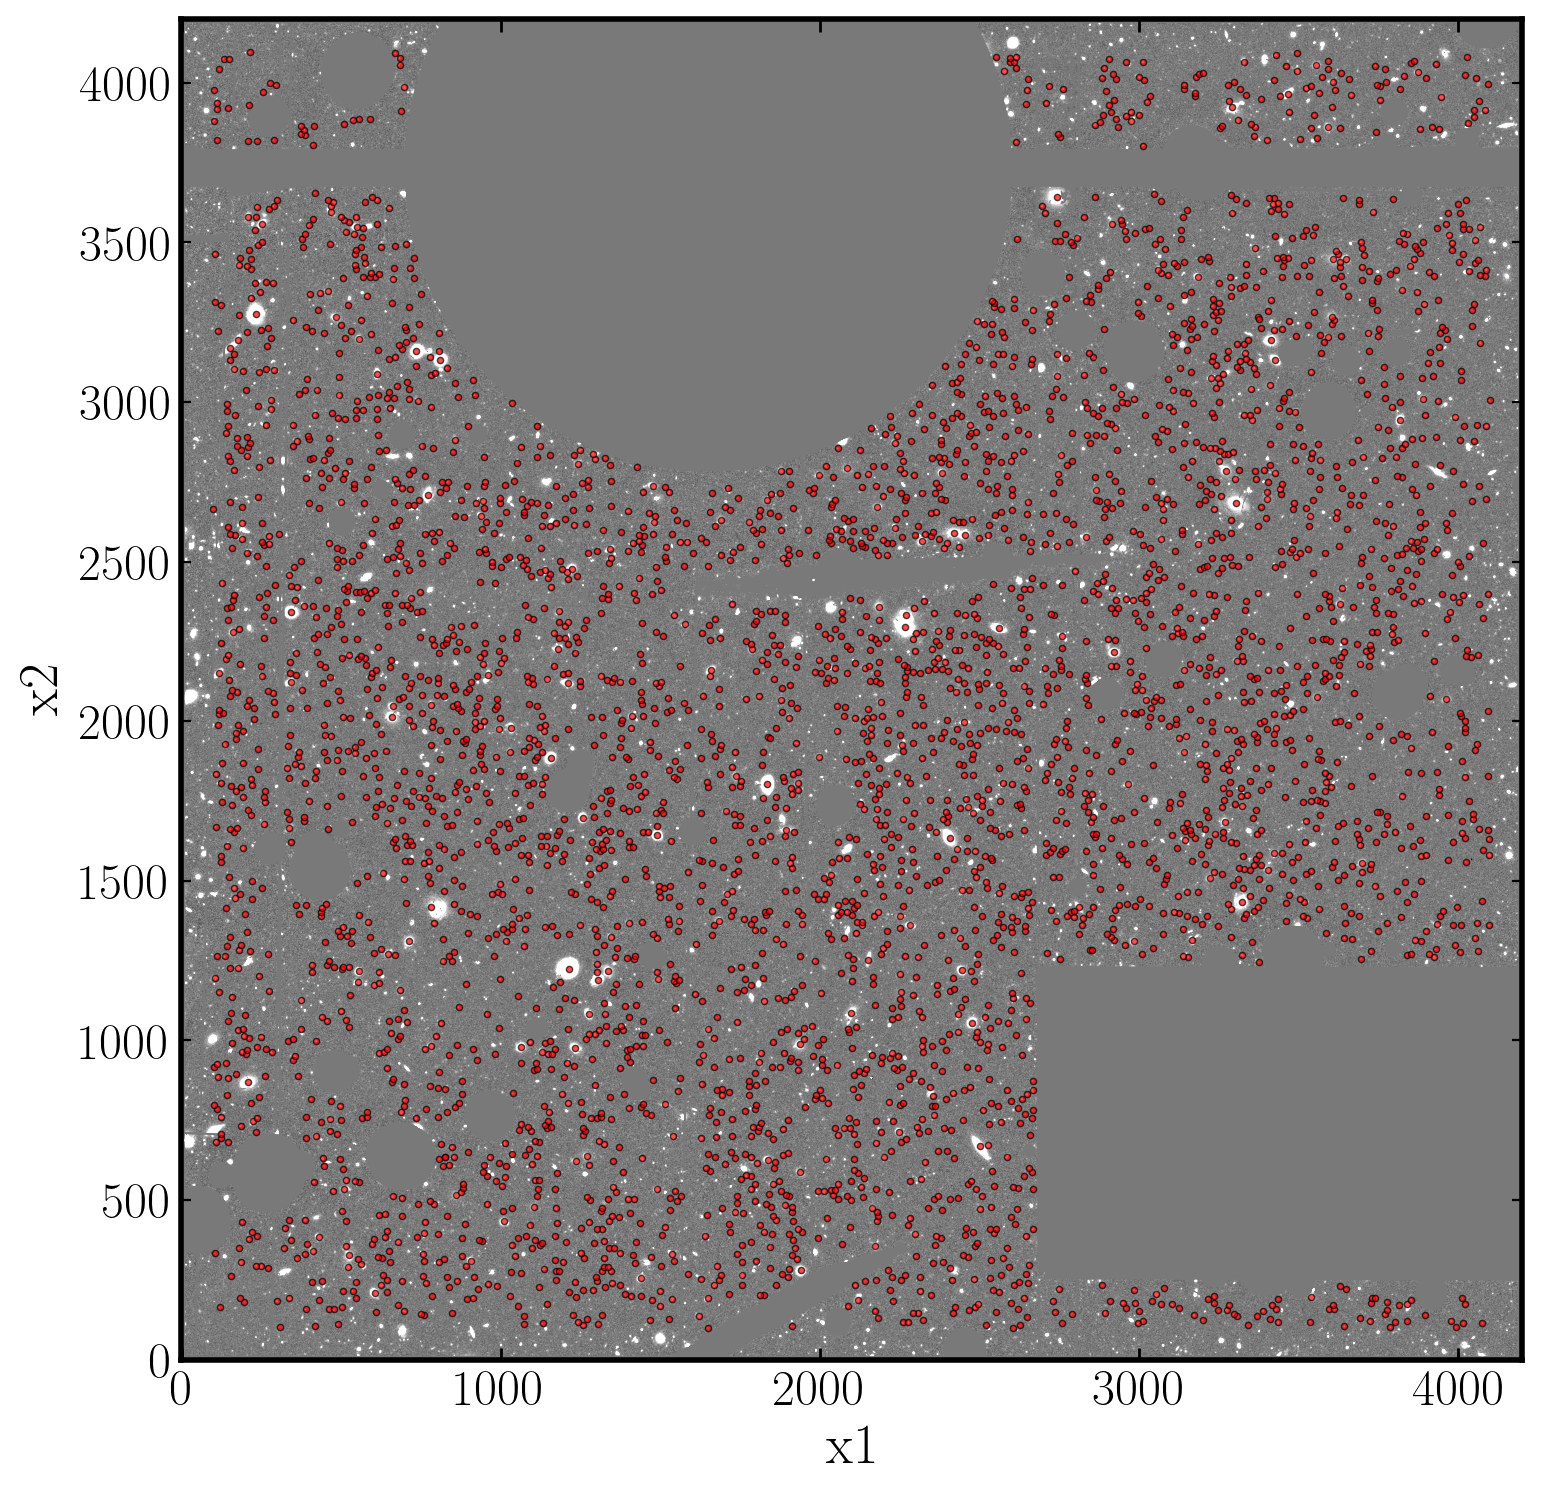

In [38]:
# Example inputs: replace with your actual data
image = data["gal_array"]
bb = exposure.getBBox()
x1 = catalog["x1"] / 0.168 - bb.beginX
x2 = catalog["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=5, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

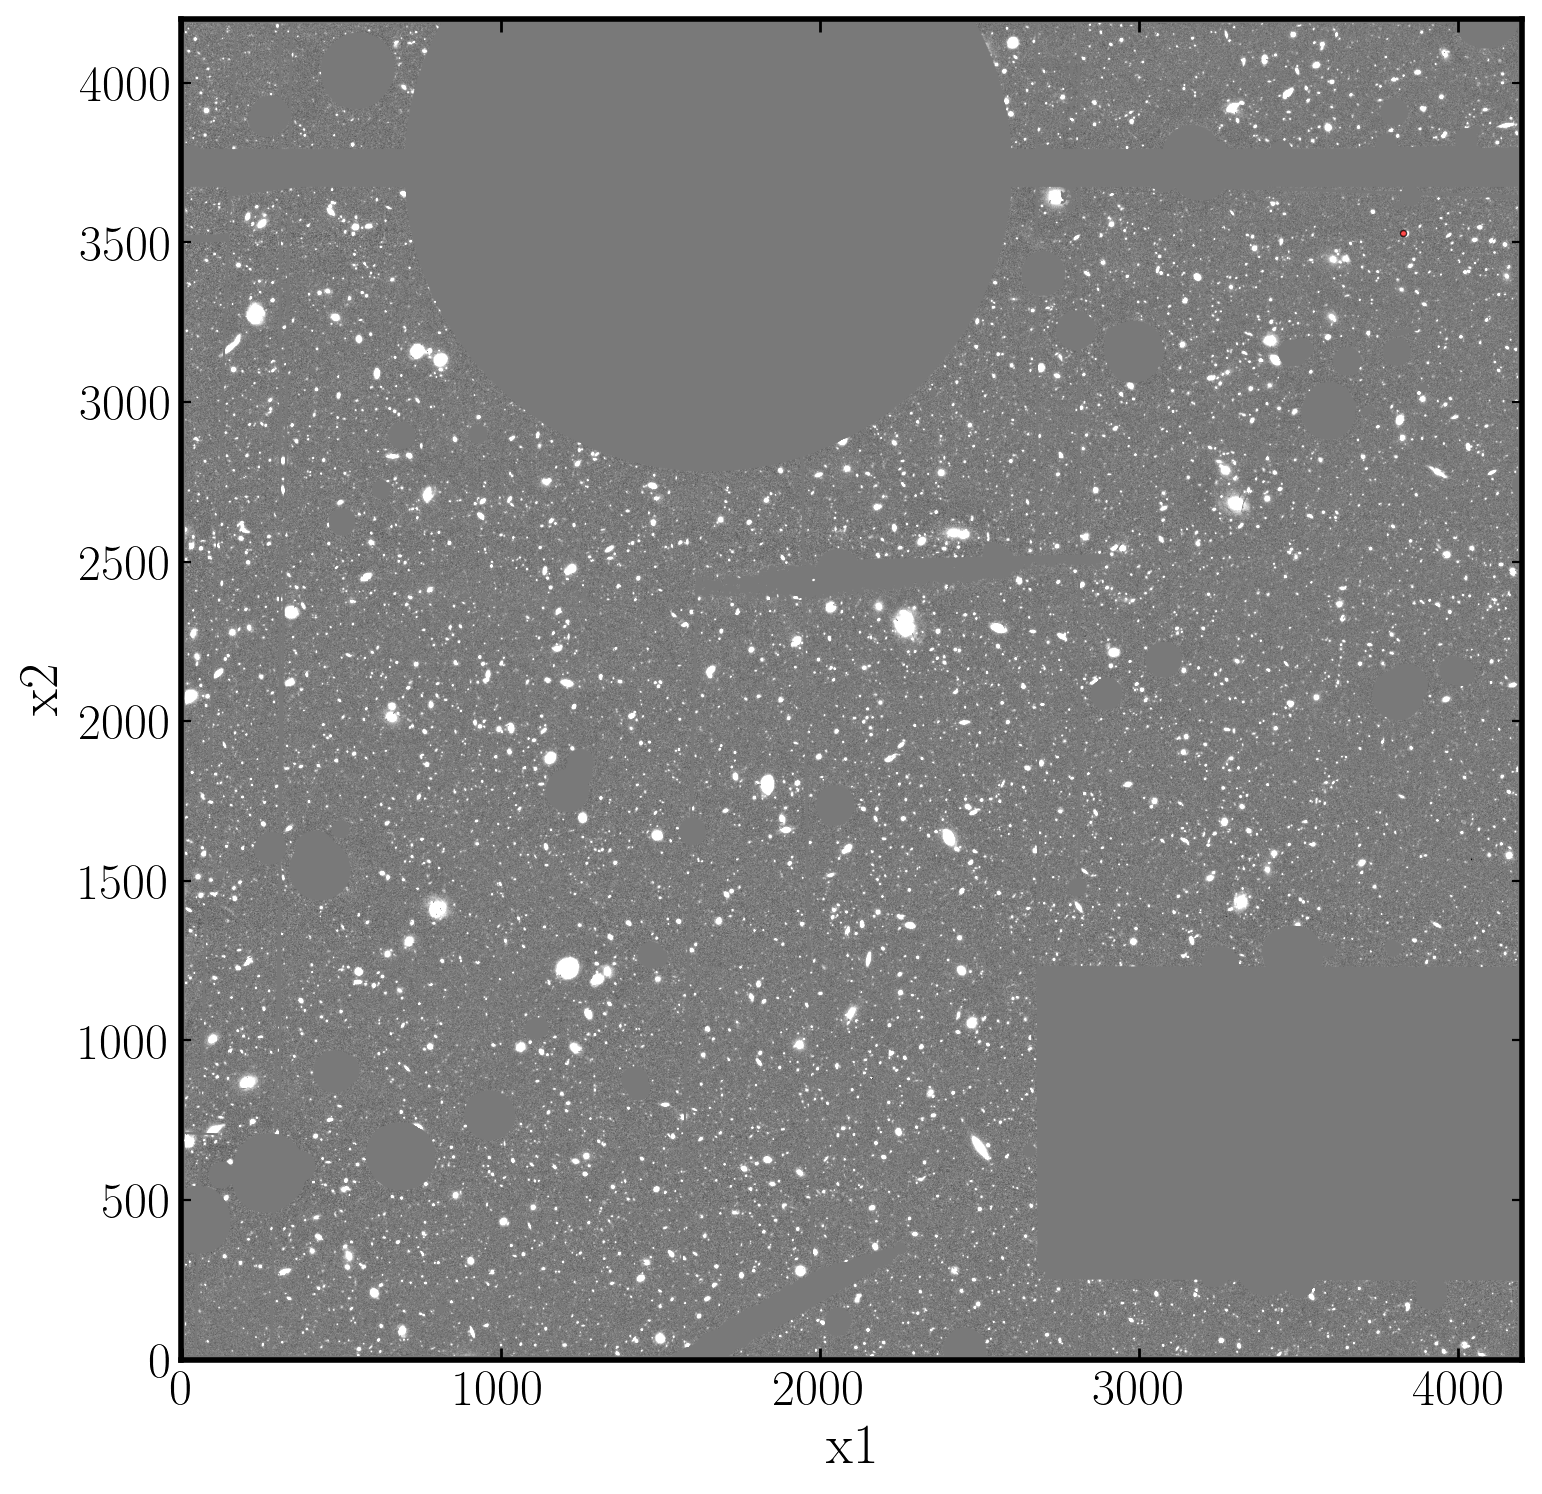

In [89]:
# Example inputs: replace with your actual data
image = data["gal_array"]
bb = exposure.getBBox()
m1 = np.abs(det["dwsel_dg1"]) > 1000
x1 = det[m1]["x1"] / 0.168 - bb.beginX
x2 = det[m1]["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=5, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

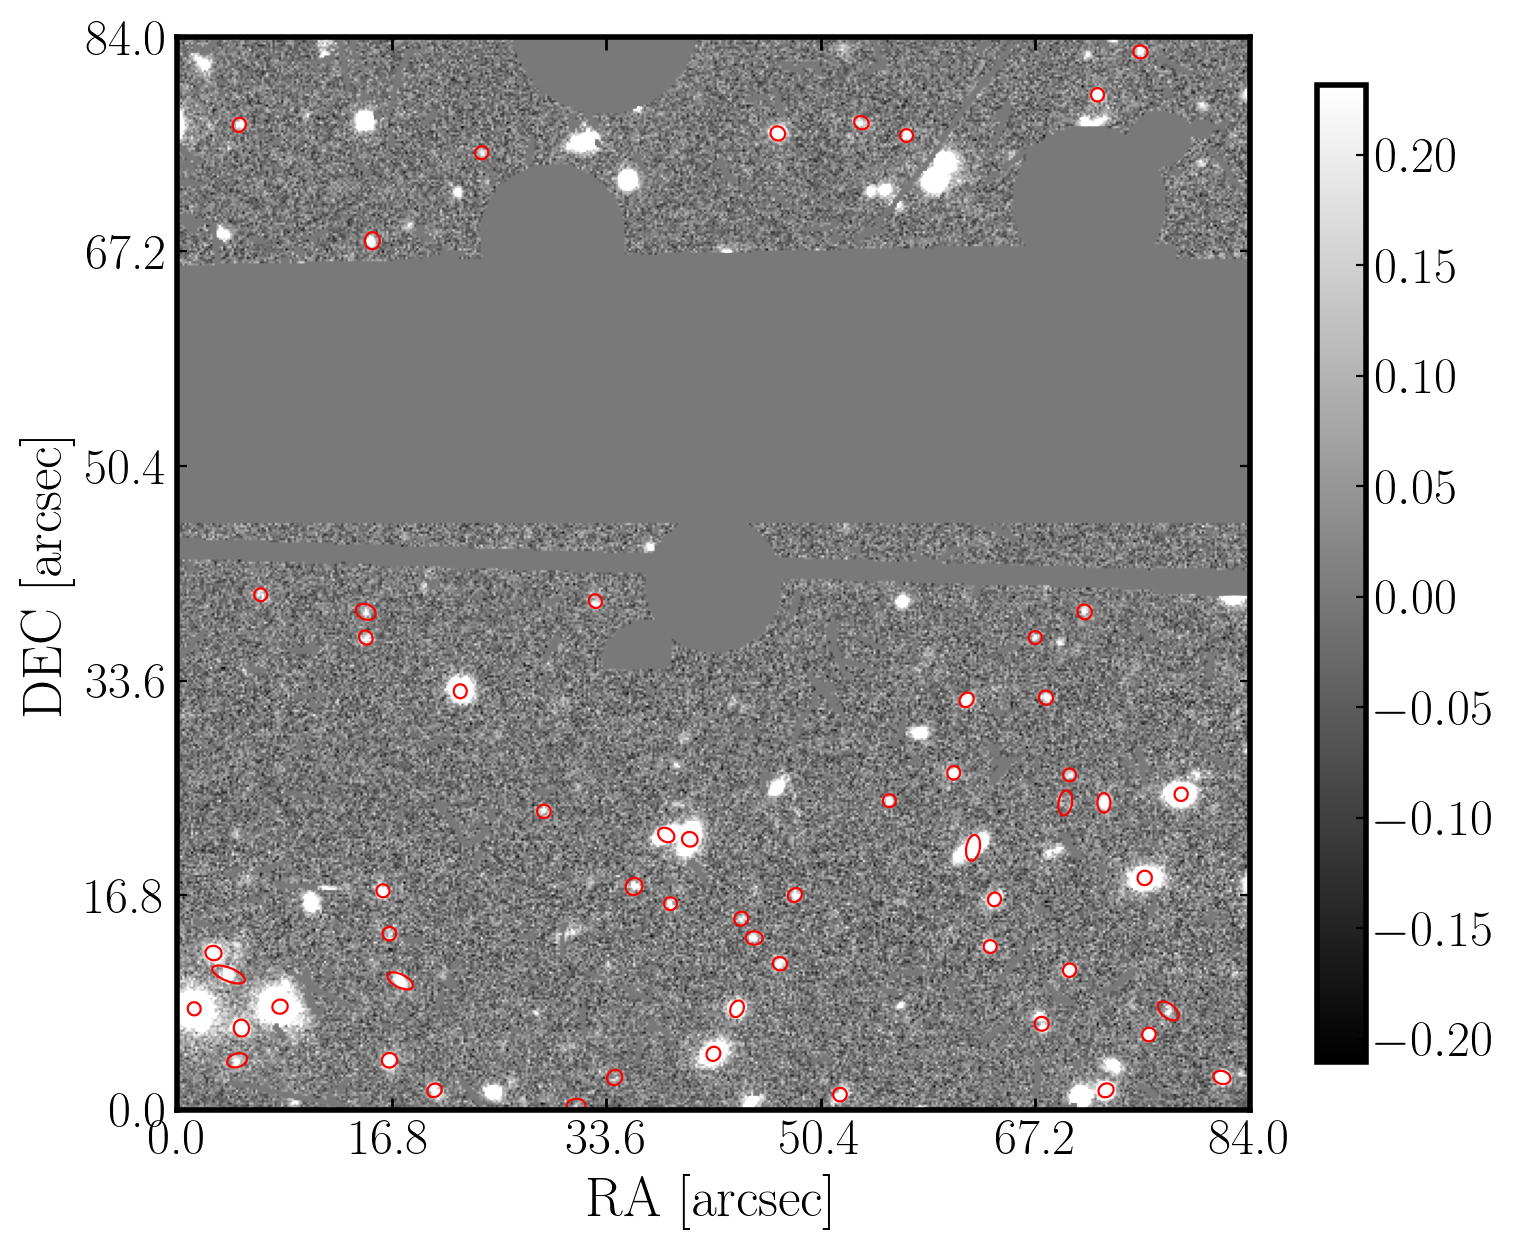

In [90]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

xmin = 3600
ymin = 3400
xmax =xmin+500
ymax = ymin+500
pixel_scale = 0.168
# Example inputs: replace with your actual data
image = data["gal_array"]
gm = (catalog["mask_value"] < 60) 
x1 = catalog["x1"][gm] / pixel_scale - bb.beginX
x2 = catalog["x2"] [gm] / pixel_scale - bb.beginY
msk = (x1> xmin) & (x1< xmax-1) & (x2> ymin-1) & (x2< ymax-1)
x1 = x1[msk] - xmin
x2 = x2[msk] - ymin
a1 = np.sqrt((catalog["a1"][gm] / pixel_scale) **2.0 + 3 ** 2.0)
a2 = np.sqrt((catalog["a2"][gm] / pixel_scale) ** 2.0  + 3 ** 2.0)
theta = catalog["t"][gm] / np.pi * 180.0

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(image[ymin: ymax, xmin:xmax], origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
patches = [
    Ellipse((xi, yi), width=2*maj, height=2*min_, angle=ang)
    for xi, yi, maj, min_, ang in zip(x1, x2, a1, a2, theta)
]

ax.add_collection(
    PatchCollection(
        patches,
        facecolor='none',
        edgecolor='red',
        linewidth=0.8,
        alpha=1.0,
        zorder=2,
    )
)

pixel_scale = 0.168
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_xticklabels([f"{(tick) * pixel_scale:.1f}" for tick in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{(tick) * pixel_scale:.1f}" for tick in yticks])
ax.set_xlim(0, (xmax - xmin))
ax.set_ylim(0, (ymax - ymin))
ax.set_xlabel("RA [arcsec]")
ax.set_ylabel("DEC [arcsec]")
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
fig.tight_layout()
plt.show()

In [56]:
e1 = catalog["fpfs_e1"] * catalog["wsel"]
r1 = (
    catalog["fpfs_de1_dg1"] *catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["fpfs_e1"]
)
print(np.sum(e1) / np.sum(r1))
print(np.sum(e1))

0.012913291232167895
10.41822223645279


In [58]:
len(catalog)

4089

In [59]:
len(det)

4242

In [57]:
print(np.sum(r1))

806.782875809405


In [46]:
r2 = (
    catalog["fpfs_de2_dg2"] *catalog["wsel"]
    + catalog["dwsel_dg2"] * catalog["fpfs_e2"]
)

In [47]:
np.sum(r2)

758.4023665906855

(array([ 87., 188., 208., 228., 245., 243., 253., 219., 249., 230., 188.,
        205., 191., 166., 155., 123., 113.,  85.,  83.,  95.,  79.,  59.,
         60.,  43.,  47.,  39.,  40.,  26.,  24.,  23.,  18.,   7.,   9.,
          5.,  14.,  10.,   5.,   9.,   3.,   3.,   1.,   2.,   3.,   0.,
          2.,   2.,   0.,   0.,   1.,   1.]),
 array([2.20529554e-04, 1.07675379e-02, 2.13145463e-02, 3.18615547e-02,
        4.24085630e-02, 5.29555714e-02, 6.35025798e-02, 7.40495882e-02,
        8.45965965e-02, 9.51436049e-02, 1.05690613e-01, 1.16237622e-01,
        1.26784630e-01, 1.37331638e-01, 1.47878647e-01, 1.58425655e-01,
        1.68972664e-01, 1.79519672e-01, 1.90066680e-01, 2.00613689e-01,
        2.11160697e-01, 2.21707705e-01, 2.32254714e-01, 2.42801722e-01,
        2.53348731e-01, 2.63895739e-01, 2.74442747e-01, 2.84989756e-01,
        2.95536764e-01, 3.06083772e-01, 3.16630781e-01, 3.27177789e-01,
        3.37724798e-01, 3.48271806e-01, 3.58818814e-01, 3.69365823e-01,
        3.

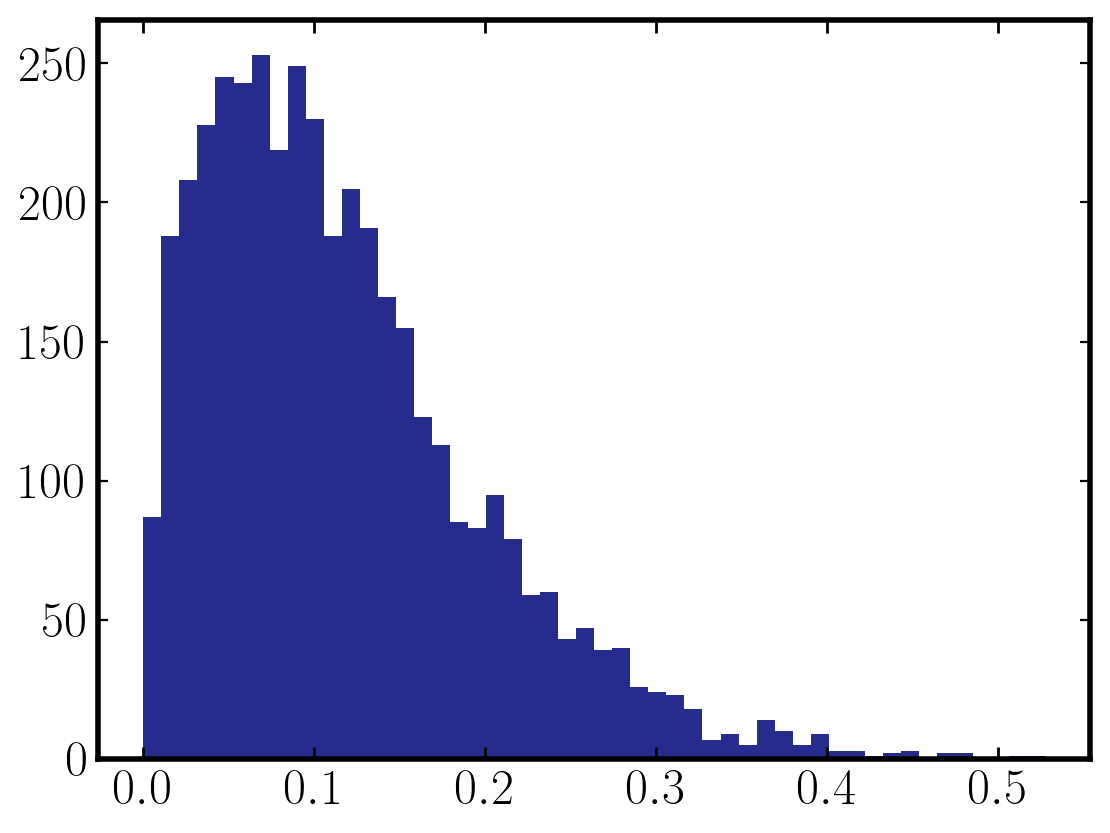

In [41]:
e1 = catalog["fpfs_e1"] 
e2 = catalog["fpfs_e2"] 
abse = np.sqrt(e1**2 + e2**2)
plt.hist(abse, bins=50)

In [42]:
mag = 27 - np.log10(catalog["flux"]) * 2.5
np.sum(catalog["wsel"][(mag<25) * (abse<0.3)]) / (4100 * 0.168 / 60) ** 2.0

18.07996477696536

In [43]:
np.sum(r1)

806.782875809405

In [44]:
e1 = catalog["e1"] * catalog["wsel"]
r1 = (
    catalog["de1_dg1"] * catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["e1"]
)
print(np.sum(e1) / np.sum(r1))

0.010662782091221406


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.13655371, -0.11655371, -0.09655371, -0.07655371, -0.05655371,
        -0.03655371, -0.01655371,  0.00344629,  0.02344629,  0.04344629,
         0.06344629,  0.08344629,  0.10344629,  0.12344629,  0.14344629,
         0.16344629,  0.18344629,  0.20344629,  0.22344629,  0.24344629,
         0.26344629,  0.28344629,  0.30344629,  0.32344629,  0.34344629,
         0.36344629,  0.38344629,  0.40344629,  0.42344629,  0.44344629,
         0.46344629,  0.48344629,  0.50344629,  0.52344629,  0.54344629,
         0.56344629,  0.58344629,  0.60344629,  0.62344629,  0.64344629,
         0.66344629,  0.68344629,  0.70344629,  0.72344629,  0.74344629,
         0.76344629,  0.78344629,  0.80344629,  0.82344629,  0.84344629,
         0.86344629]),
 <BarContainer object

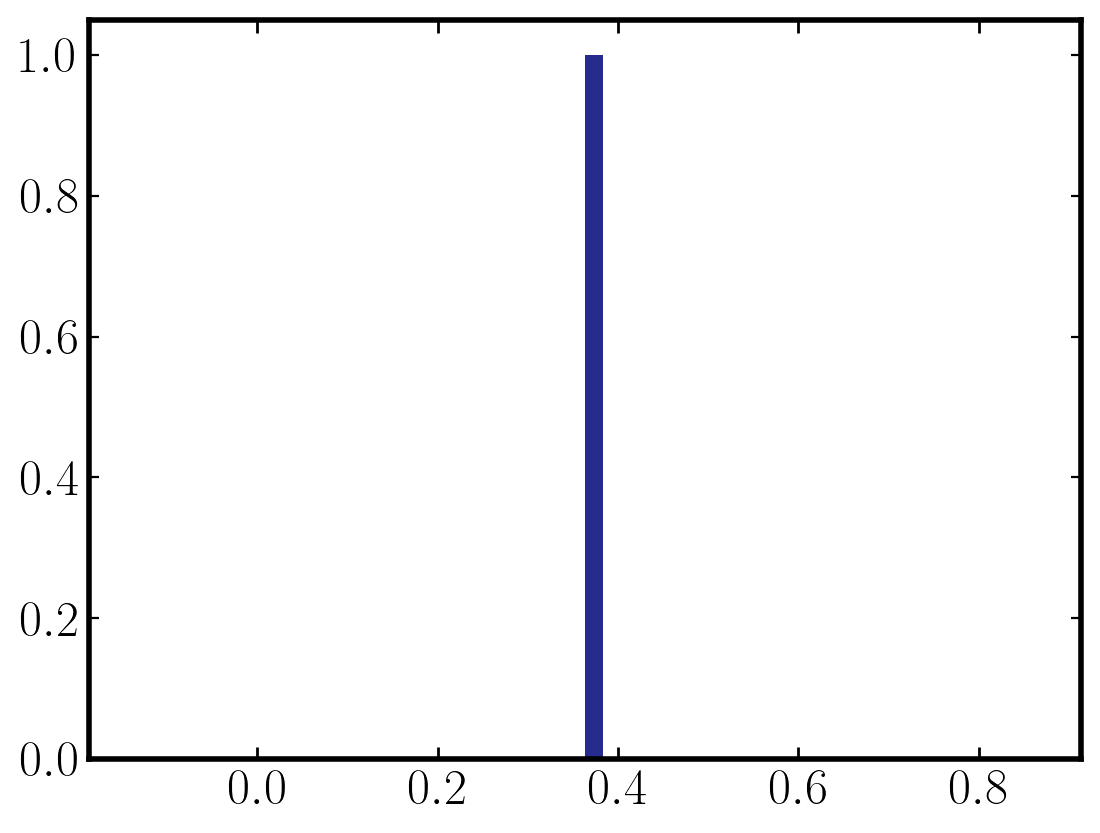

In [45]:
plt.hist(np.std(catalog["wsel"]), bins=50)